<a href="https://colab.research.google.com/github/VMBoehm/NormalizingFlows/blob/master/mixing_stepwise_Compression_RealNVP_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Normalizing flow with dimensionality reduction

---


### orthogonal mixing-compression matrix






In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
! pip install -q https://github.com/dfm/corner.py/archive/master.zip
import corner

     / 11.1MB 20.7MB/s


In [4]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
import tensorflow_datasets as dts
tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.contrib.distributions import softplus_inverse

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
import os

from google.colab import drive

ROOT = "/content/gdrive"
drive.mount(ROOT, force_remount=True)

PROJ = "My Drive/NormalizingFlow" 
PROJECT_PATH = os.path.join(ROOT, PROJ)
print(PROJECT_PATH)
if not os.path.isdir(PROJECT_PATH):
  os.makedirs(PROJECT_PATH)

module_dir= os.path.join(PROJECT_PATH, 'module/')


Mounted at /content/gdrive
/content/gdrive/My Drive/NormalizingFlow


In [6]:
#mnist = tf.keras.datasets.fashion_mnist
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train = (x_train/256.).reshape((-1,28*28))
x_test  = (x_test/256.).reshape((-1,28*28))

11493376/11490434 [==============================] - 0s 0us/step


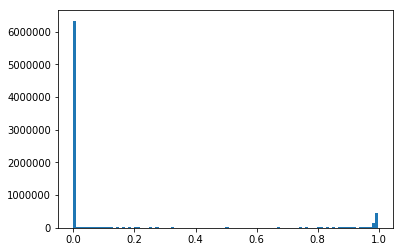

In [7]:
_= hist(x_test.flatten(),bins=100)

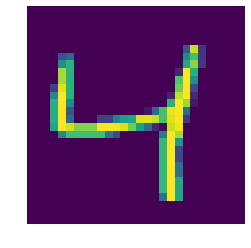

In [8]:
imshow(x_train[2].reshape((28,28)))
axis('off')
show()

define different data transforms

In [0]:
from scipy.ndimage import gaussian_filter
from sklearn.decomposition import PCA

class data_trafo():
  
  def __init__(self, types, params):
    
    self.types = types
    self.params= params
    
  def __call__(self,x):
    
    if 'dequantize':
      x = x + np.random.rand(*x.shape)/256.0
    
    if 'smooth' in self.types:
      for ii in range(len(x)):
        # overwrites, but that's ok, because we dont need the inverse
        x[ii]=gaussian_filter(x[ii].reshape((-1,28,28)), sigma=self.params['sigma']).flatten()    
    
    if 'mask' in self.types:
      try:
         x=x[:,self.mask]
      except:
        x, mask   = self.mask_data(x)
        self.mask = mask
          
    if 'shift_rescale' in self.types:
      x-=0.5
      x*=10
  
    if 'pca' in self.types:
      try:
        self.dec
      except:
        pca      = PCA(n_components=self.params['n_comp'])
        self.dec = pca.fit(x)
      x        = self.dec.transform(x)
      
      
    if 'logit_transform' in self.types:
      x = self.rescale(x,self.params['alpha'])
    
  
    if 'box_cox' in self.types:
      x, mean, mini = self.box_cox(x,self.params['lambda'])
      try:
        self.mini
      except:
        self.mini=mini
      try:
        self.mean
      except:
        self.mean=mean
      
    return x
  
  def inverse(self,y):
    
    if 'box_cox' in self.types:
      y = self.inverse_box_cox(y,self.mean, self.mini, self.params['lambda'])
    
    if 'logit_transform' in self.types:
      y = self.inverse_rescale(y,self.params['alpha'])
    
    if 'pca' in self.types:
      y = self.dec.inverse_transform(y)
      
    if 'shift_rescale' in self.types:
      y/=10
      y+=0.5   
    
    if 'mask' in self.types:
      y = self.inverse_mask(y)
           
    return y
  
  
  def mask_data(self,x):
    st_dev = x.std(axis=0)
    mask   = np.where(st_dev>5e-2)[0]
    y      = x[:,mask]
    return y, mask
  
  def inverse_mask(self,y):
    x = np.zeros((len(y),28*28))
    x[:,self.mask] = y
    return x
  
  
  def logit(self,x):
    return log(x/(1.-x))
  
  def inverse_logit(self,y):
    #=sigmoid
    return exp(y)/(exp(y)+1)
    
    
  def rescale(self,x,alpha):
    return self.logit((alpha+(1.-2.*alpha)*x))
  
  def inverse_rescale(self,y,alpha):
    return (((self.inverse_logit(y)-alpha)/(1.-2.*alpha)))
  
  
  def box_cox(self,x,l):
    minimum = np.amin(x)
    x = x-minimum*1.1
    x = (x**l-1.)/l
    mean = np.expand_dims(x.mean(),0)
    x-=mean
    return x, mean, minimum
  
  def inverse_box_cox(self,y,mean, minimum,l):
    y+=mean
    y = y*l+1.
    y = y**(1/l)
    y+=minimum*1.1
    return y
  

In [0]:
dt           = data_trafo(['dequantize','logit_transform'],{'sigma':1., 'lambda':1.4, 'n_comp':400, 'alpha':1e-6})
x_train_prep = dt(x_train)

In [0]:
x_test_prep = dt(x_test)

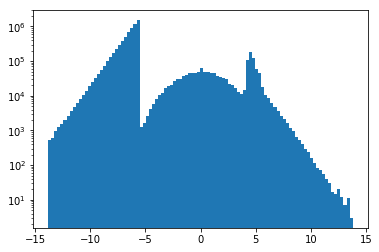

In [12]:
_= hist(x_test_prep.flatten(),bins=100, log=True)

In [13]:
import keras 
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
datagen = ImageDataGenerator(rotation_range=10.)
datagen.fit(x_train_prep.reshape(-1,28,28,1))

In [15]:
data_dim    = x_train_prep.shape[-1]
batch_size  = 128
nvp_depth   = 4
nvp_dim     = 100
dim_red     = data_dim-nvp_dim
print('chosen dimensionality reduction: %d -> %d, in percent %d'%(data_dim,dim_red, dim_red/data_dim*100))

chosen dimensionality reduction: 784 -> 684, in percent 87


In [16]:
plot_dir     = os.path.join(PROJECT_PATH, 'plots/')
plot_path    = os.path.join(plot_dir, 'compression_nvp','latent_dim%d'%nvp_dim)
print(plot_path)
if not os.path.isdir(plot_path):
  os.makedirs(plot_path)

/content/gdrive/My Drive/NormalizingFlow/plots/compression_nvp/latent_dim100


In [0]:
my_gen  = datagen.flow(x_train_prep.reshape(-1,28,28,1), batch_size=batch_size)

getting checkerboard permutations

In [18]:
#get checkerboard
a = np.arange(0,data_dim,2)
b = np.arange(1,data_dim+1,2)

alternating_permutation = np.append(a,b)
print(alternating_permutation.shape)

#permute first and second half
a = np.arange(0,data_dim//2)
b = np.arange(data_dim//2,data_dim)
swapping_permutation = np.append(b,a)
print(swapping_permutation.shape)

np.random.seed(10101)

random_permutations = [np.random.permutation(np.arange(data_dim)) for ii in range(30)]

permutations = []
permutations.append(alternating_permutation)
for ii in range(len(random_permutations)):
  permutations.append(swapping_permutation)
  #permutations.append(random_permutations[ii])

(784,)
(784,)


In [0]:
def get_prior():
    return tfd.MultivariateNormalDiag(tf.zeros([nvp_dim]), scale_identity_multiplier=1.0, name ='prior')
  
  
def init_once(x, name):
  return tf.get_variable(name, initializer=x, trainable=False)
  
  
class DimRed(tfb.Bijector):
  def __init__(self, input_dim, output_dim, batch_size,validate_args=False, name="dim_red"):
    super(DimRed, self).__init__(
        is_constant_jacobian=True,
        validate_args=validate_args,
        forward_min_event_ndims=output_dim,
        inverse_min_event_ndims=output_dim,
        name=name)
    print(input_dim,output_dim)
    self.is_injective = False
    self.indices      = tf.constant(np.arange(input_dim),dtype=tf.int32)
    self.shape        = tf.constant([output_dim,batch_size, 1])

  def _forward(self, x):
    return x

  def _inverse(self, y):    
    updates       = tf.gather(y,self.indices,axis=-1)
    updates       = tf.expand_dims(tf.transpose(updates),-1)
    y_comp        = tf.scatter_nd(tf.expand_dims(self.indices,-1), updates, self.shape)
    y_comp        = tf.squeeze(tf.transpose(y_comp))
    return y_comp

  def _inverse_log_det_jacobian(self, y):
    return tf.constant(0., y.dtype)

  def _forward_log_det_jacobian(self, x):
    return tf.constant(0., x.dtype)

In [0]:

class Orthogonal(tfb.Bijector):
  """Orthogonal matrix Bijector using optimization over the Stiefel manifold.
  """

  def __init__(self,
               input_dim,
               output_dim,
               validate_args=False,
               name=None):
    """Creates the MatvecLU bijector.
    Args:
        Default value: `False`.
      name: Python `str` name given to ops managed by this object.
        Default value: `None` (i.e., "MatvecLU").
    Raises:
      ValueError: If both/neither `channels` and `lower_upper`/`permutation` are
        specified.
    """
    with tf.name_scope(name or 'Orthogonal') as name:
      with tf.variable_scope('%s/orthogonal_stiefel'%name, reuse=tf.AUTO_REUSE,use_resource=False):
        self._mat = tf.get_variable('A', [input_dim, output_dim], dtype=tf.float32,
                            initializer=tf.orthogonal_initializer())

    super(Orthogonal, self).__init__(
        is_constant_jacobian=True,
        forward_min_event_ndims=1,
        validate_args=validate_args,
        name=name)

  @property
  def matrix(self):
    return self._mat

  def _forward(self, x):
    return tf.tensordot(x, tf.transpose(self._mat), axes=[[-1], [0]])

  def _inverse(self, y):
    return tf.tensordot(y, self._mat, axes=[[-1], [0]])

  def _forward_log_det_jacobian(self, x):
    return constant_op.constant(0., x.dtype.base_dtype)

In [0]:
from tensorflow.python.ops import nn_ops
from tensorflow.python.framework import ops
from tensorflow.python.ops import template as template_ops
from tensorflow.python.layers import core as layers
from tensorflow.python.ops import array_ops
import tensorflow.compat.v1 as tf1
from tensorflow_probability.python.internal import tensorshape_util

def my_real_nvp_default_template(
    hidden_layers,
    shift_only=False,
    activation=nn_ops.relu,
    name=None,
    *args,
    **kwargs):
  """Build a scale-and-shift function using a multi-layer neural network.
  This will be wrapped in a make_template to ensure the variables are only
  created once. It takes the `d`-dimensional input x[0:d] and returns the `D-d`
  dimensional outputs `loc` ("mu") and `log_scale` ("alpha").
  Arguments:
    hidden_layers: Python `list`-like of non-negative integer, scalars
      indicating the number of units in each hidden layer. Default: `[512, 512].
    shift_only: Python `bool` indicating if only the `shift` term shall be
      computed (i.e. NICE bijector). Default: `False`.
    activation: Activation function (callable). Explicitly setting to `None`
      implies a linear activation.
    name: A name for ops managed by this function. Default:
      "real_nvp_default_template".
    *args: `tf.compat.v1.layers.dense` arguments.
    **kwargs: `tf.compat.v1.layers.dense` keyword arguments.
  Returns:
    shift: `Float`-like `Tensor` of shift terms ("mu" in
      [Papamakarios et al.  (2016)][1]).
    log_scale: `Float`-like `Tensor` of log(scale) terms ("alpha" in
      [Papamakarios et al. (2016)][1]).
  Raises:
    NotImplementedError: if rightmost dimension of `inputs` is unknown prior to
      graph execution.
  #### References
  [1]: George Papamakarios, Theo Pavlakou, and Iain Murray. Masked
       Autoregressive Flow for Density Estimation. In _Neural Information
       Processing Systems_, 2017. https://arxiv.org/abs/1705.07057
  """


  with tf.name_scope(name or 'real_nvp_default_template'):

    def _fn(x, output_units, **condition_kwargs):
      """Fully connected MLP parameterized via `real_nvp_template`."""
      if condition_kwargs:
        raise NotImplementedError(
            'Conditioning not implemented in the default template.')

      if tensorshape_util.rank(x.shape) == 1:
        x = x[tf.newaxis, ...]
        reshape_output = lambda x: x[0]
      else:
        reshape_output = lambda x: x
        
      with tf.variable_scope('%s/inner_layers'%name, reuse=tf.AUTO_REUSE,use_resource=False):
        for units in hidden_layers:
          x = tf1.layers.dense(
              inputs=x,
              units=units,
              activation=activation,
              *args,  # pylint: disable=keyword-arg-before-vararg
              **kwargs)
        x = tf1.layers.dense(
            inputs=x,
            units=(1 if shift_only else 2) * output_units,
            activation=None,
            *args,  # pylint: disable=keyword-arg-before-vararg
            **kwargs)
      if shift_only:
        return reshape_output(x), None
      shift, log_scale = tf.split(x, 2, axis=-1)
      return reshape_output(shift), reshape_output(log_scale)

    return tf1.make_template('real_nvp_default_template', _fn)


In [0]:

# def get_nvp():
#   chain         = []
#   perms         = [tfb.Permute(permutation=init_once(permutations[ii],name="permutation%d"%ii)) for ii in range(nvp_depth)]
#   masked_frac   = 0.5
#   factor        = np.ceil((data_dim/nvp_dim)**(1./len(nvp_size)))
#   print(factor)
  
#   current_dim = nvp_dim
#   for i,s in enumerate(nvp_size):
#     #if i%2==0:
#     new_dim     = min(factor*current_dim,data_dim)
#     print(current_dim,new_dim)
#     chain.append(Orthogonal(input_dim=current_dim, output_dim=new_dim,name='red_dim%d'%i))
#     current_dim = new_dim
    
#     mask_part   = np.int32(np.floor(current_dim*masked_frac))

      
#     template = my_real_nvp_default_template(hidden_layers=s,name='nvp%d'%i,shift_only=True)

#     chain.append(tfb.RealNVP(num_masked=mask_part,shift_and_log_scale_fn=template,name='nvp_layer%d'%i))
#       #chain.append(perms[i])
                 
#   return tfb.Chain(chain,name='nvp_chain')



def get_nvp():
  chain         = []
  masked_frac   = 0.5
  factor        = np.ceil((data_dim/nvp_dim)**(1./len(nvp_size)))
  print(factor)
  
  current_dim = nvp_dim
  for i,s in enumerate(nvp_size):
    if i==0:
      new_dim     = data_dim #min(factor*current_dim,data_dim)      
    if i==(nvp_depth-1):
      new_dim     = data_dim
    print(current_dim,new_dim)
    chain.append(Orthogonal(input_dim=current_dim, output_dim=new_dim,name='red_dim%d'%i))
    current_dim = new_dim
    
    mask_part   = np.int32(np.floor(current_dim*masked_frac))

    if i>1:
      template = my_real_nvp_default_template(hidden_layers=s,name='nvp%d'%i,shift_only=True)
    else:
      template = my_real_nvp_default_template(hidden_layers=s,name='nvp%d'%i,shift_only=True)

    chain.append(tfb.RealNVP(num_masked=mask_part,shift_and_log_scale_fn=template,name='nvp_layer%d'%i))
                 
  return tfb.Chain(chain,name='nvp_chain')

In [0]:
def nvp_module_spec():
    x_sample     = tf.placeholder(tf.float32, shape=[None,data_dim])
    u_sample     = tf.placeholder(tf.float32, shape=[None,nvp_dim])

    nvp_         = get_nvp()
   
    bwd_pass     = nvp_.forward(x_sample)
    fwd_pass     = nvp_.inverse(u_sample)
    

    hub.add_signature(inputs={'x_sample':x_sample,'u_sample':u_sample},outputs={'bwd_pass': bwd_pass, 'fwd_pass': fwd_pass})

In [0]:
from tensorflow.python.training import training_ops

class RMSpropNatGrad(tf.train.Optimizer):
    """ RMSProp optimizer with the capability to do natural gradient steps.
        Inspired by: https://github.com/stwisdom/urnn/blob/master/custom_optimizers.py
        See also:
        Full-Capacity Unitary Recurrent Neural Networks, Wisdom et al, at:
        https://arxiv.org/abs/1611.00035
    """

    def __init__(self, learning_rate, decay=0.9, momentum=0.0,
                 epsilon=1e-10, global_step=None, nat_grad_normalization=False,
                 qr_steps=-1, name='RMSpropNatGrad'):
        """
            Create an RMSProp Stiefel-manifold hybrid optimizer.
            learning_rate: Stes the global learning rate for all updates.
            (Please note Wisdom uses seperate learning rates for the RMSProp
            and Stiefel updates.)
            decay:  Discounting factor for the history/coming gradient
            momentum: A scalar tensor.
            epsilon:  Small value to avoid zero denominator.
            global_step: The global step, used to decide when to run
                         the qr re-normalization.
            nat_grad_normalization: If True, the Stiefel gradient will be
                                    normalized as well.
            qr_steps: When to run the qr re-normalization. -1 means never.
            (Setting this value leads to a Stiefel manifold, projected
            gradient descent hybrid approach. Not used in the paper.)
            name: The name for your optimizer.
        """
        if global_step is not None:
            self._global_step_tensor = global_step
        else:
            raise ValueError("global_step tensor must be missing.")

        use_locking = False
        super().__init__(use_locking, name)
        self._learning_rate = learning_rate
        self._decay = decay
        self._momentum = momentum
        self._epsilon = epsilon
        self._nat_grad_normalization = nat_grad_normalization
        self._debug = False
        if qr_steps > 0:
            self._qr_steps = int(qr_steps)
        else:
            self._qr_steps = None

        # Tensors for learning rate and momentum.  Created in _prepare.
        self._learning_rate_tensor = None
        self._decay_tensor = None
        self._momentum_tensor = None
        self._epsilon_tensor = None

        # print("training params:", self._learning_rate, self._decay, self._momentum)

    def _create_slots(self, var_list):
        """ Set up rmsprop slots for all variables."""
        for v in var_list:
            init_rms = tf.ones_initializer(dtype=v.dtype)
            self._get_or_make_slot_with_initializer(v, init_rms, v.get_shape(),
                                                    v.dtype, "rms", self._name)
            self._zeros_slot(v, "momentum", self._name)
            init_eps = tf.constant_initializer(self._epsilon)
            self._get_or_make_slot_with_initializer(v, init_eps, v.get_shape(),
                                                    v.dtype, "eps", self._name)

    def _prepare(self):
        """Convert algorthm parameters to tensors. """
        self._learning_rate_tensor = tf.convert_to_tensor(self._learning_rate,
                                                          name="learning_rate")
        self._decay_tensor = tf.convert_to_tensor(self._decay, name="decay")
        self._momentum_tensor = tf.convert_to_tensor(self._momentum,
                                                     name="momentum")
        self._epsilon_tensor = tf.convert_to_tensor(self._epsilon,
                                                    name="epsilon")

    def _summary_A(self, A):
        # test A's skew symmetrie:
        test_a = tf.transpose(tf.conj(A)) - (-A)
        test_a_norm = tf.real(tf.norm(test_a))
        tf.summary.scalar('A.H--A', test_a_norm)

    def _summary_C(self, C):
        # C must be unitary/orthogonal:
        eye = tf.eye(*tf.Tensor.get_shape(C).as_list(), dtype=C.dtype)
        test_c = eye - tf.matmul(tf.transpose(tf.conj(C)), C)
        test_c_norm = tf.real(tf.norm(test_c))
        tf.summary.scalar('I-C.HC', test_c_norm)

    def _summary_W(self, W):
        # W must also be unitary/orthogonal:
        eye = tf.eye(*tf.Tensor.get_shape(W).as_list(), dtype=W.dtype)
        test_w = eye - tf.matmul(tf.transpose(tf.conj(W)), W)
        test_w_norm = tf.real(tf.norm(test_w))
        tf.summary.scalar('I-W.HW', test_w_norm)

    def re_unitarize(self, W):
        # This should be a proper projection according to:
        # A Projection Method for Optimization Problems on the Stiefel Manifold
        s, u, v = tf.linalg.svd(W)
        W = tf.matmul(u, v, adjoint_b=True)
        W = tf.Print(W, [tf.constant(0)], 'step with qr.')
        return W

    def _apply_dense(self, grad, var):
        rms = self.get_slot(var, "rms")
        mom = self.get_slot(var, "momentum")
        eps = self.get_slot(var, 'eps')
        tf.summary.scalar('grad_norm', tf.norm(grad))
        # debug_here()
        if 'orthogonal_stiefel' in var.name and 'bias' not in var.name:
            with tf.variable_scope("orthogonal_update"):
                print('Appling an orthogonality preserving step to', var.name)
                # apply the rms update rule.
                new_rms = self._decay_tensor * rms + (1. - self._decay_tensor) \
                    * tf.square(grad)
                rms_assign_op = tf.assign(rms, new_rms)
                # scale the gradient.
                if self._nat_grad_normalization:
                    grad = grad / (tf.sqrt(rms) + eps)
                # the update should preserve orthogonality.
                grad_shape = tf.Tensor.get_shape(grad).as_list()
                # W_new_lst = []
                eye = tf.eye(grad_shape[0], dtype=tf.float32)
                G = grad
                W = var
                # A = tf.matmul(tf.transpose(G), W) - tf.matmul(tf.transpose(W), G)
                A = tf.matmul(G, tf.transpose(W)) - tf.matmul(W, tf.transpose(G))
                cayleyDenom = eye + (self._learning_rate_tensor/2.0) * A
                cayleyNumer = eye - (self._learning_rate_tensor/2.0) * A
                C = tf.matmul(tf.matrix_inverse(cayleyDenom), cayleyNumer)
                W_new = tf.matmul(C, W)
                if self._debug:
                    # self._summary_A(A)
                    self._summary_C(C)
                    self._summary_W(W)

                # Reunitarize after n steps.
                if self._qr_steps is not None:
                    W_new = tf.cond(tf.equal(tf.mod(self._global_step_tensor,
                                         self._qr_steps), 0),
                                lambda: self.re_unitarize(W_new), lambda: W_new)
                var_update_op = tf.assign(var, W_new)
                return tf.group(*[var_update_op, rms_assign_op])
        elif 'unitary_stiefel' in var.name and 'bias' not in var.name:
            with tf.variable_scope("unitary_update"):
                print('Appling an unitarity preserving step to', var.name)
                # apply the rms update rule.
                new_rms = self._decay_tensor * rms + (1. - self._decay_tensor) \
                    * tf.square(grad)
                rms_assign_op = tf.assign(rms, new_rms)
                # scale the gradient.
                if self._nat_grad_normalization:
                    grad = grad / (tf.sqrt(new_rms) + eps)
                # do an update step, which preserves unitary structure.
                # checking shapes.
                grad_shape = tf.Tensor.get_shape(grad).as_list()
                assert grad_shape[0] == grad_shape[1]
                eye = tf.eye(grad_shape[0], dtype=tf.complex64)
                G = tf.complex(grad[:, :, 0], grad[:, :, 1])
                W = tf.complex(var[:, :, 0], var[:, :, 1])

                # Reunitarize after n steps.
                if self._qr_steps is not None:
                    W = tf.cond(tf.equal(tf.mod(self._global_step_tensor,
                                         self._qr_steps), 0),
                                lambda: self.re_unitarize(W), lambda: W)

                A = tf.matmul(G, tf.conj(tf.transpose(W))) \
                    - tf.matmul(W, tf.conj(tf.transpose(G)))
                # A must be skew symmetric.
                larning_rate_scale = tf.complex(self._learning_rate_tensor/2.0,
                                                tf.zeros_like(self._learning_rate_tensor))
                cayleyDenom = eye + larning_rate_scale * A
                cayleyNumer = eye - larning_rate_scale * A
                C = tf.matmul(tf.matrix_inverse(cayleyDenom), cayleyNumer)
                W_new = tf.matmul(C, W)
                if self._debug:
                    # self._summary_A(A)
                    self._summary_C(C)
                    self._summary_W(W)
                # debug_here()
                W_new_re = tf.real(W_new)
                W_new_img = tf.imag(W_new)
                W_array = tf.stack([W_new_re, W_new_img], -1)
                var_update_op = tf.assign(var, W_array)
                return tf.group(*[var_update_op, rms_assign_op])
        else:
            # do the usual RMSprop update
            if 1:
                # tensorflow default.
                print('Appling standard rmsprop to', var.name)
                return training_ops.apply_rms_prop(
                    var, rms, mom,
                    tf.cast(self._learning_rate_tensor, var.dtype.base_dtype),
                    tf.cast(self._decay_tensor, var.dtype.base_dtype),
                    tf.cast(self._momentum_tensor, var.dtype.base_dtype),
                    tf.cast(self._epsilon_tensor, var.dtype.base_dtype),
                    grad, use_locking=False).op
            else:
                # My rmsprop implementation.
                new_rms = self._decay_tensor * rms \
                    + (1. - self._decay_tensor) * tf.square(grad)
                rms_assign_op = tf.assign(rms, new_rms)
                W_new = var - self._learning_rate_tensor * grad / (tf.sqrt(new_rms) + eps)
                var_update_op = tf.assign(var, W_new)
                return tf.group(*[var_update_op, rms_assign_op])

    def _apply_sparse(self, grad, var):
        raise NotImplementedError("Sparse gradient updates are not supported.")

In [28]:

tf.reset_default_graph()


lr            = tf.placeholder_with_default(0.01,shape=[])


sigma         = tf.placeholder_with_default(0.1,shape=[])


prior         = get_prior()

x_tr          = tf.placeholder(shape=[None,data_dim], dtype=tf.float32)



### ----------- NVP ----------- ###|

nvp_size      = [[1024, 1024] for ii in range(nvp_depth)]

print(x_tr.shape)

# print(fwd_pass)

nvp_spec      = hub.create_module_spec(nvp_module_spec)

nvp_funcs     = hub.Module(nvp_spec, name='nvp_funcs',trainable=True)

nvp_ = get_nvp()

bwd_pass      = nvp_.forward(x_tr)#nvp_funcs({'x_sample':x_tr,'u_sample':np.zeros((batch_size,nvp_dim))},as_dict=True)['bwd_pass']

bwd_pass      = tf.stop_gradient(bwd_pass)

fwd_pass      = nvp_.inverse(bwd_pass)#nvp_funcs({'x_sample':np.zeros((batch_size,data_dim)), 'u_sample':bwd_pass},as_dict=True)['fwd_pass']



likelihood    = tfd.MultivariateNormalDiag(loc=fwd_pass, scale_identity_multiplier=sigma)

loss          = - tf.reduce_mean(likelihood.log_prob(x_tr))

global_step = tf.train.get_or_create_global_step()
optimizer = RMSpropNatGrad(learning_rate=lr, global_step=global_step)
opt_op = optimizer.minimize(loss)


# # ---------------------------end train nvp ----------------- #

#comment train nvp above section above and uncomment this for loading the trained module

#nvp_funcs     = hub.Module(nvp_func_path, trainable=False)

(?, 784)
2.0
100 784
784 784
784 784
784 784
2.0
100 784
784 784
784 784
784 784
Appling an orthogonality preserving step to red_dim0//orthogonal_stiefel/A:0
Appling an orthogonality preserving step to red_dim1//orthogonal_stiefel/A:0
Appling an orthogonality preserving step to red_dim2//orthogonal_stiefel/A:0
Appling an orthogonality preserving step to red_dim3//orthogonal_stiefel/A:0
Appling standard rmsprop to real_nvp_default_template/nvp3/inner_layers/dense/kernel:0
Appling standard rmsprop to real_nvp_default_template/nvp3/inner_layers/dense/bias:0
Appling standard rmsprop to real_nvp_default_template/nvp3/inner_layers/dense_1/kernel:0
Appling standard rmsprop to real_nvp_default_template/nvp3/inner_layers/dense_1/bias:0
Appling standard rmsprop to real_nvp_default_template/nvp3/inner_layers/dense_2/kernel:0
Appling standard rmsprop to real_nvp_default_template/nvp3/inner_layers/dense_2/bias:0
Appling standard rmsprop to real_nvp_default_template_1/nvp2/inner_layers/dense/kernel:

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

**Training of the NVP**

In [0]:
nvp_loss = []
nvp_sigma= []
nepoch = 0

In [32]:
ii     = 0

learning_rate = 1e-8

#train the nvp
while nepoch<400:
  x = my_gen.next()
  if len(x)==batch_size:
    if (ii+1)*batch_size>len(x_train_prep): 
      ii=0
      nepoch+=1
      print('starting epoch', nepoch)
    if nepoch>20:
      learning_rate=1e-4
    if nepoch>20:
      learning_rate=1e-5
    x_truth = x.reshape(-1,28*28)
    _, ll,s = sess.run([opt_op,loss,sigma], feed_dict={x_tr: x_truth, lr: learning_rate})
    nvp_loss+=[ll]
    nvp_sigma+=[s]
    if ii%100==0:
      print(ll, s)
  ii+=1

1383239.4 0.1
284105.75 0.1
275854.78 0.1
267606.5 0.1
263454.0 0.1
starting epoch 1
257178.03 0.1


KeyboardInterrupt: ignored

In [33]:
ll =[]
for ii in range(len(x_test_prep)//batch_size):
  ll.append(sess.run([loss], feed_dict={x_tr:x_test_prep[ii*batch_size:(ii+1)*batch_size]}))
print(mean(ll))

ll =[]
for ii in range(len(x_train_prep)//batch_size):
  ll.append(sess.run([loss], feed_dict={x_tr:x_train_prep[ii*batch_size:(ii+1)*batch_size]}))
print(mean(ll))

296970.5


KeyboardInterrupt: ignored

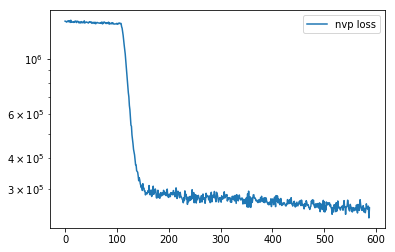

In [34]:
plt.figure()
semilogy(nvp_loss[::],label='nvp loss')
legend()
#plt.savefig(os.path.join(plot_path+'/loss.png'),bbox_inches='tight')

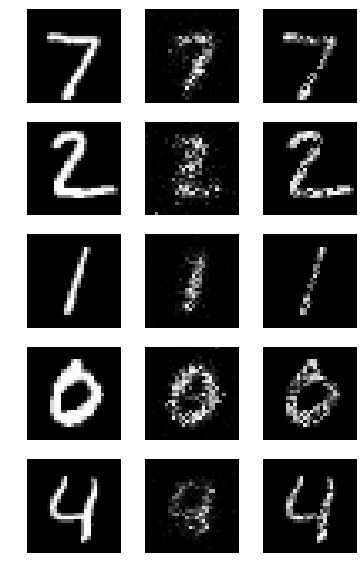

In [35]:
x_input      = x_test_prep[:batch_size,:]

decode       = sess.run(fwd_pass, feed_dict={x_tr: x_input})
num_examples = 5

x_input      = dt.inverse(x_input)
decode       = dt.inverse(decode)
diff         = x_input-decode

i=1
plt.figure(figsize=(3*2,num_examples*2))
for index in range(num_examples):
  plt.subplot(num_examples,3,i)
  i+=1
  imshow(x_input[index].reshape((28,28)),vmax=1,vmin=0,cmap='gray')
  axis('off')
  plt.subplot(num_examples,3,i)
  i+=1  
  plt.subplots
  imshow(decode[index].reshape((28,28)),vmax=1,vmin=0,cmap='gray')
  axis('off')
  plt.subplot(num_examples,3,i)
  i+=1
  imshow(diff[index].reshape((28,28)),vmax=1,vmin=0,cmap='gray')
  axis('off')
#plt.savefig(os.path.join(plot_path+'/','recons.pdf'),bbox_inches='tight')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


(64, 784)


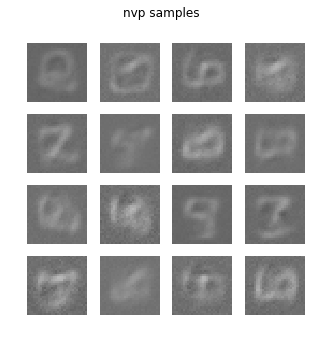

In [0]:

prior_sample = sess.run(prior.sample(batch_size))
samples_nvp  = sess.run(nvp_funcs({'x_sample':x_truth,'u_sample':prior_sample},as_dict=True)['fwd_pass'])

data_space  = dt.inverse(samples_nvp)
print(data_space.shape)

figure(figsize=(5,5))
suptitle('nvp samples')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.reshape(data_space[i],(28,28)),cmap='gray',vmin=0,vmax=1); #colorbar()
    axis('off')
#plt.savefig(os.path.join(plot_path+'/','samples.pdf'),bbox_inches='tight')

In [0]:
num = 20#len(x_test_prep)//batch_size
latent_space = np.zeros((num*batch_size,data_dim))
for ii in range(num):
  latent_space[ii*batch_size:(ii+1)*batch_size,:]=sess.run(nvp_funcs({'x_sample':x_test_prep[ii*batch_size:(ii+1)*batch_size],'u_sample':np.zeros((batch_size,data_dim))},as_dict=True)['bwd_pass'])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


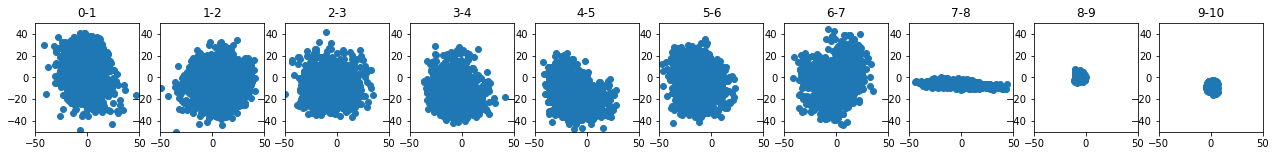

In [0]:
plt.figure(figsize=(2.2*(nvp_dim+2),2))
for i in range(nvp_dim+2):
  plt.subplot(1,nvp_dim+2,i+1)
  plt.title('%d-%d'%(i,i+1))
  plt.scatter(latent_space[:,i],latent_space[:,i+1])
  plt.xlim(-50,50)
  plt.ylim(-50,50)
plt.savefig(os.path.join(plot_path+'/','latent_space_dis.pdf'),bbox_inches='tight')

In [0]:
nvp_func_path    = os.path.join(module_dir, 'compression_nvp','latent_dim%d'%nvp_dim)
print(nvp_func_path)
if not os.path.isdir(nvp_func_path):
  os.makedirs(nvp_func_path)

/content/gdrive/My Drive/NormalizingFlow/module/compression_nvp/latent_dim8


In [0]:
nvp_funcs.export(nvp_func_path,sess)

AlreadyExistsError: ignored